In [1]:
import pandas as pd
import os
import sqlite3
import matplotlib.pylab as plt
from scipy import stats
import numpy as np
%config Completer.use_jedi = False #for auto complete code

In [2]:
#para el ttest pvalue debe ser mayor a 0.05 para aceptar de que son la misma muestra
def tables_in_sqlite_db(conn):
    cursor = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = [
        v[0] for v in cursor.fetchall()
        if v[0] != "sqlite_sequence"
    ]
    cursor.close()
    return tables

class Estacion:
    def __init__(self,database):
        self.database = database
        sql_query= "SELECT * FROM Maestro"
        self.Maestro = pd.read_sql(sql_query, conn)
        
        
        self.tables_clima={}
        self.stats_previous_historic=[]

    def get_Maestro(self):
        return self.Maestro

    def estaciones_por_dz(self,num):
        self.tables_dz={}
        tables = tables_in_sqlite_db(self.database)
        filtro= self.Maestro[self.Maestro.DZ==num]
        name=list(filtro.NOMBRE_ESTACION+' '+filtro.CATEGORIA)
        
        for i,estacion in enumerate(filtro.CODIGO):
            estacion='T'+str(estacion)
            if estacion in tables:
                sql_query= "SELECT * FROM "+estacion
                
                self.tables_dz[name[i]]=pd.read_sql(sql_query, conn)
                
        return self.tables_dz
    
        
class Convencional(Estacion):
    def __init__(self,**kwargs):
        super(Convencional,self).__init__(**kwargs)
    
    def plot_dz_niveles(self):
        for estacion in self.tables_dz:
            df = self.tables_dz[estacion]
            df.columns=['Codigo','Estacion','Fecha Reg','ano','mes','dia','Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med','Caudal']
            df[['Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med']]=df[['Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med']].apply(pd.to_numeric,errors='coerce')
            df.plot(x='Fecha Reg',y=['Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med'],figsize = (25,10),title=estacion)
        plt.show()
        
    def stats_dz_niveles(self):
        for estacion in self.tables_dz:
            df = self.tables_dz[estacion]
            print(estacion)
            print(df[['Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med']].describe())
    
    
    def max_historic_and_previous(self):
        for estacion in self.tables_dz:
            df=self.tables_dz[estacion]
            df.columns=['Codigo','Estacion','Fecha Reg','ano','mes','dia','Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med','Caudal']
            
            cols=['Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med']
            df[cols]=df[cols].apply(pd.to_numeric,errors='coerce')
            
            #Todos los anos presentes en la base de datos
            idx_years=pd.DatetimeIndex(df['Fecha Reg']).year
            years=np.unique(idx_years)
            if len(years)>=2:
                year0=years[0]
                previous_year=years[-2]
                present_year=years[-1]

                #year evaluation
                df_previous=df[idx_years==previous_year]
                df_historic=df[idx_years!=present_year]

                #month evaluation
                month_previous=pd.DatetimeIndex(df_previous['Fecha Reg']).month
                avenida_previous=(month_previous==1) | (month_previous==2) | (month_previous==3) | (month_previous==4)
                estiaje_previous=(month_previous==6) | (month_previous==7) | (month_previous==8) | (month_previous==9)

                month_historic = pd.DatetimeIndex(df_historic['Fecha Reg']).month
                avenida_historic=(month_historic==1) | (month_historic==2) | (month_historic==3) | (month_historic==4)
                estiaje_historic=(month_historic==6) | (month_historic==7) | (month_historic==8) | (month_historic==9)


                Estacion_niveles= [estacion+' '+col for col in cols]

                stats_df={}
                stats_df['Estaciones']=Estacion_niveles
                #stats_df['max año previo '+str(previous_year)]=list(df_previous[cols].max())
                #stats_df['max historico '+str(year0)+'-'+str(previous_year)]=list(df_historic[cols].max())
                stats_df['max año previo']=list(df_previous[cols].max())
                stats_df['max historico']=list(df_historic[cols].max())

                stats_df['max año previo estiaje']=df_previous[estiaje_previous][cols].max()
                stats_df['max año previo avenida']=df_previous[avenida_previous][cols].max()

                stats_df['max año historico estiaje']=list(df_historic[estiaje_historic][cols].max())
                stats_df['max año historico avenida']=list(df_historic[avenida_historic][cols].max())
                self.stats_previous_historic.append(pd.DataFrame(stats_df))
            else:
                print(estacion+ 'tiene menos de dos años de registro '+str(years))

            
        
        return self.stats_previous_historic
    
class Automatica(Estacion):
    pass

      

In [3]:
conn = sqlite3.connect('../data/DZ/niveles.db')
Estacion_convencional=Convencional(database=conn)

In [4]:
Estacion_convencional.get_Maestro().head(10)

INVENTARIO_SINCERADO  DZ NOMBRE_ESTACION    CODIGO     CATEGORIA  \
0                   NO   3        EL_TAMBO    211003  CONVENCIONAL   
1                   NO   3        EL_TAMBO  47E0A2A8    AUTOMATICA   
2                   NO   3    PUENTE_COINA    211004  CONVENCIONAL   
3                   NO   3    PUENTE_COINA  472E74CC    AUTOMATICA   
4                   NO   3  PUENTE_PALMIRA    211002  CONVENCIONAL   
5                   NO   3  PUENTE_PALMIRA  472E5220    AUTOMATICA   
6                   NO   4         AUTISHA    202903  CONVENCIONAL   
7                   NO   4        CALLANCA  47E244AE    AUTOMATICA   
8                   NO   4       CUCHUANCA  47E2323E    AUTOMATICA   
9                   NO   4       OBRAJILLO    202802  CONVENCIONAL   

  CLASIFICACION                TIPO    COMUNICACION FECHA_DE_INSTALACION  \
0           HLM         HIDROLÓGICA        SIN_DATO  2022-04-08 00:00:00   
1          EHMA  HIDROMETEOROLÓGICA  SATELITAL GOES             06/02/15   
2           HLM         HIDROLÓGICA        SIN_DATO             SIN_DATO   
3          EHMA  HIDROMETEOROLÓGICA  SATELITAL GOES             SIN_DATO   
4           HLM         HIDROLÓGICA        SIN_DATO             SIN_DATO   
5          EHMA  HIDROMETEOROLÓGICA  SATELITAL GOES             SIN_DATO   
6           HLM         HIDROLÓGICA        PLANILLA             01/10/14   
7           EHA         HIDROLÓGICA  SATELITAL GOES             23/09/14   
8           EHA         HIDROLÓGICA  SATELITAL GOES             23/09/14   
9           HLG         HIDROLÓGICA      VOZ Y DATA             25/09/68   

  ESTADO_FUNCIONAMIENTO ESTADO_OPERATIVIDAD    LATITUD   LONGITUD  \
0           FUNCIONANDO           OPERATIVO  -7.573976 -78.706554   
1           FUNCIONANDO           OPERATIVO  -7.573976 -78.706554   
2           FUNCIONANDO           OPERATIVO  -7.796364 -78.380122   
3           FUNCIONANDO           OPERATIVO  -7.796364 -78.380122   
4           FUNCIONANDO           OPERATIVO  -7.549189 -78.810514   
5           FUNCIONANDO           OPERATIVO  -7.549189 -78.810514   
6           FUNCIONANDO        INOPERATIVO* -11.735228 -76.606583   
7           FUNCIONANDO           OPERATIVO -11.388869 -76.769525   
8           FUNCIONANDO           OPERATIVO -11.201578 -76.788094   
9           FUNCIONANDO           OPERATIVO -11.452928 -76.622172   

  Lat_Sexagesimal Lot_Sexagesimal  ALTITUD DEPARTAMENTO   PROVINCIA  \
0    -7°34'26.31"   -78°42'23.59"    688.0  LA LIBERTAD  GRAN CHIMÚ   
1    -7°34'26.31"   -78°42'23.59"    688.0  LA LIBERTAD  GRAN CHIMÚ   
2    -7°47'46.91"   -78°22'48.44"   1823.0  LA LIBERTAD      OTUZCO   
3    -7°47'46.91"   -78°22'48.44"   1823.0  LA LIBERTAD      OTUZCO   
4    -7°32'57.08"   -78°48'37.85"    647.0  LA LIBERTAD  GRAN CHIMÚ   
5    -7°32'57.08"   -78°48'37.85"    647.0  LA LIBERTAD  GRAN CHIMÚ   
6    -11°44'6.82"    -76°36'23.7"   2152.0         LIMA  HUAROCHIRI   
7   -11°23'19.93"   -76°46'10.29"   2616.0         LIMA      HUARAL   
8    -11°12'5.68"   -76°47'17.14"   2310.0         LIMA      HUARAL   
9   -11°27'10.54"   -76°37'19.82"   2706.0         LIMA       CANTA   

                   DISTRITO COD_Clima  
0                    MARMOT  D (i) B'  
1                    MARMOT  D (i) B'  
2                    USQUIL  D (i) B'  
3                    USQUIL  D (i) B'  
4                    CASCAS  D (i) B'  
5                    CASCAS  D (i) B'  
6               SAN ANTONIO  D (i) B'  
7                  SUMBILCA  D (i) B'  
8  VEINTISIETE DE NOVIEMBRE  D (i) B'  
9          SAN BUENAVENTURA  D (i) B'

# Estaciones de la DZ 4

C:\Users\jose\anaconda3\envs\work_env\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


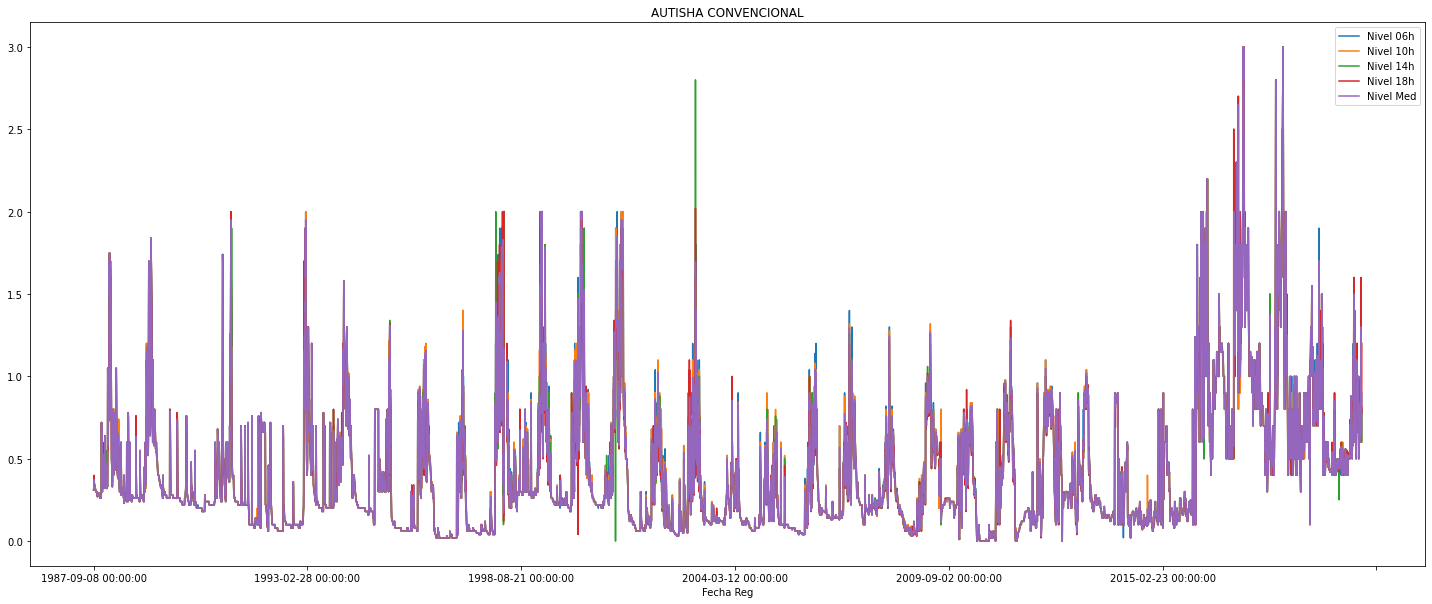

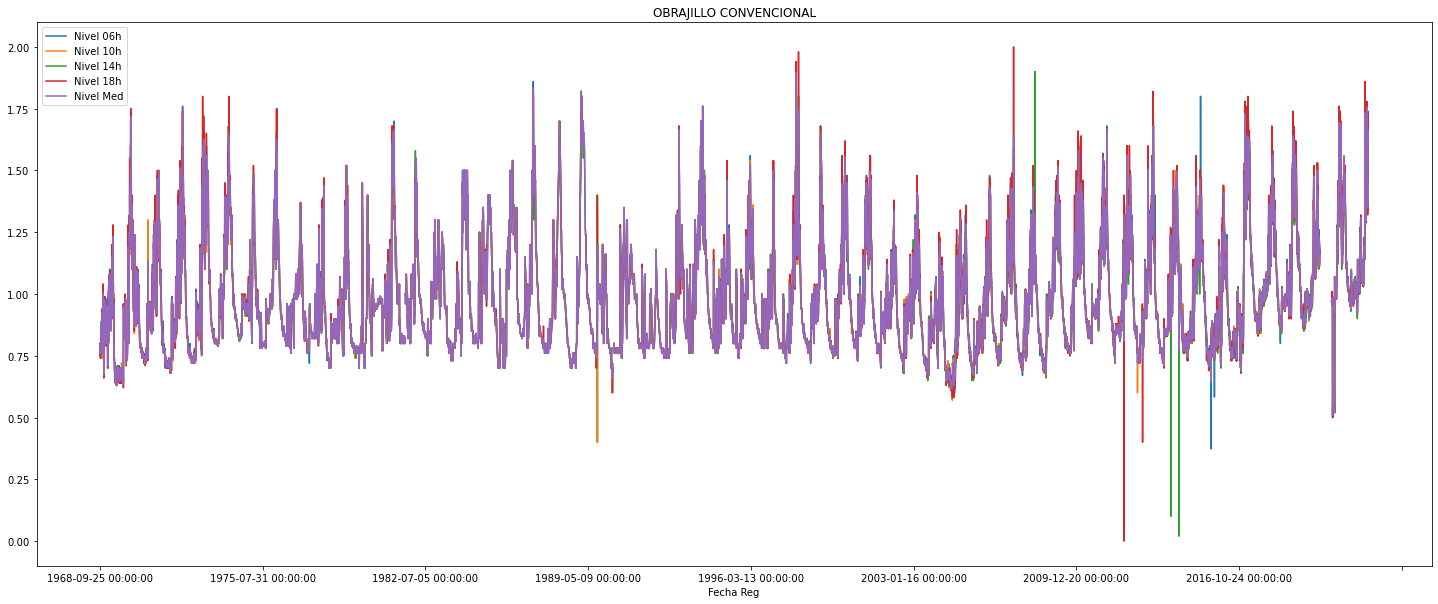

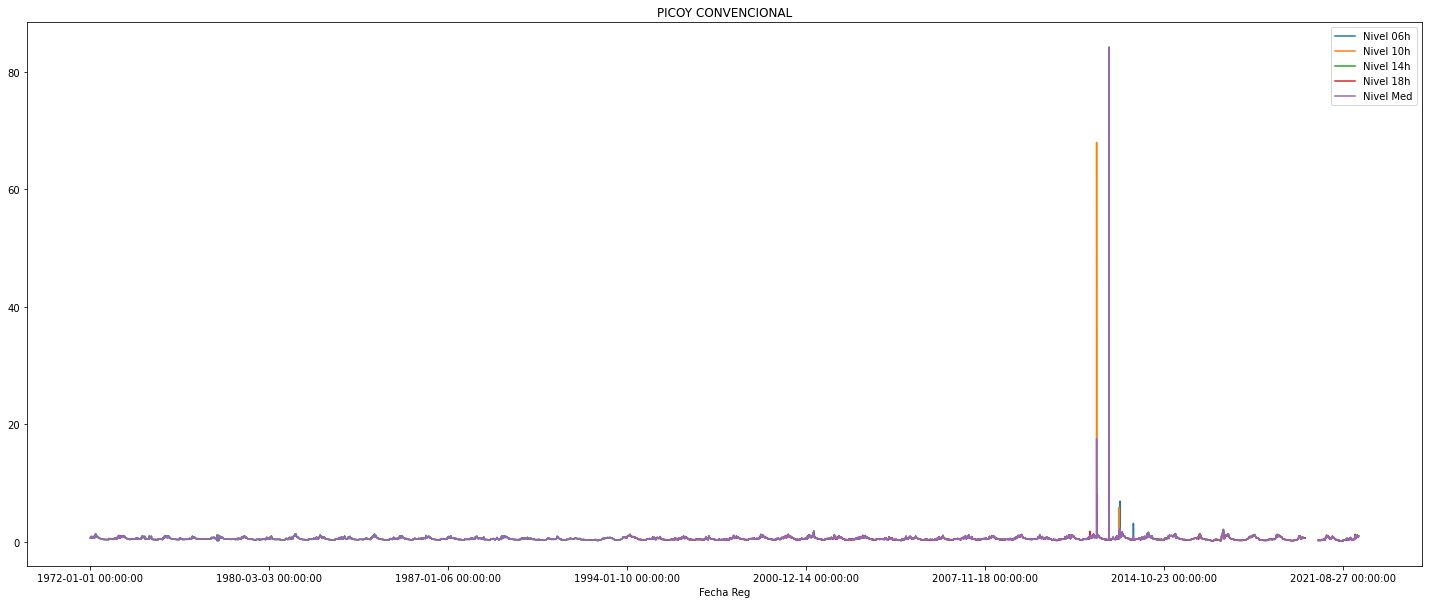

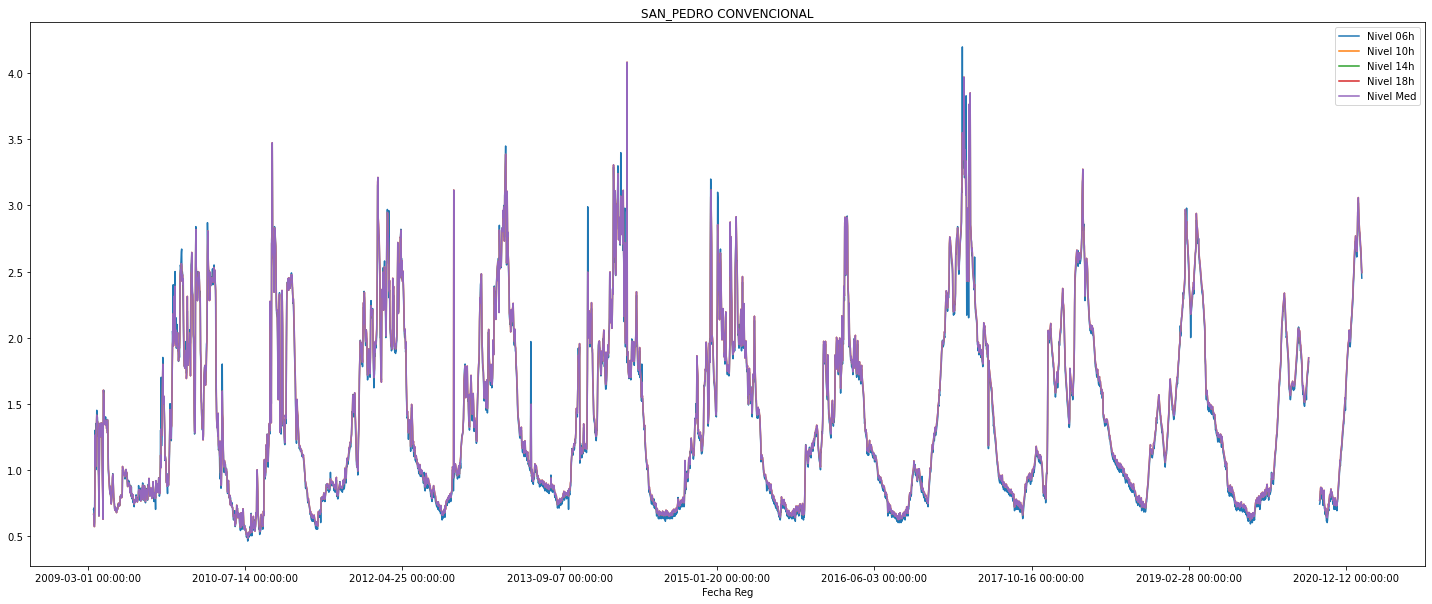

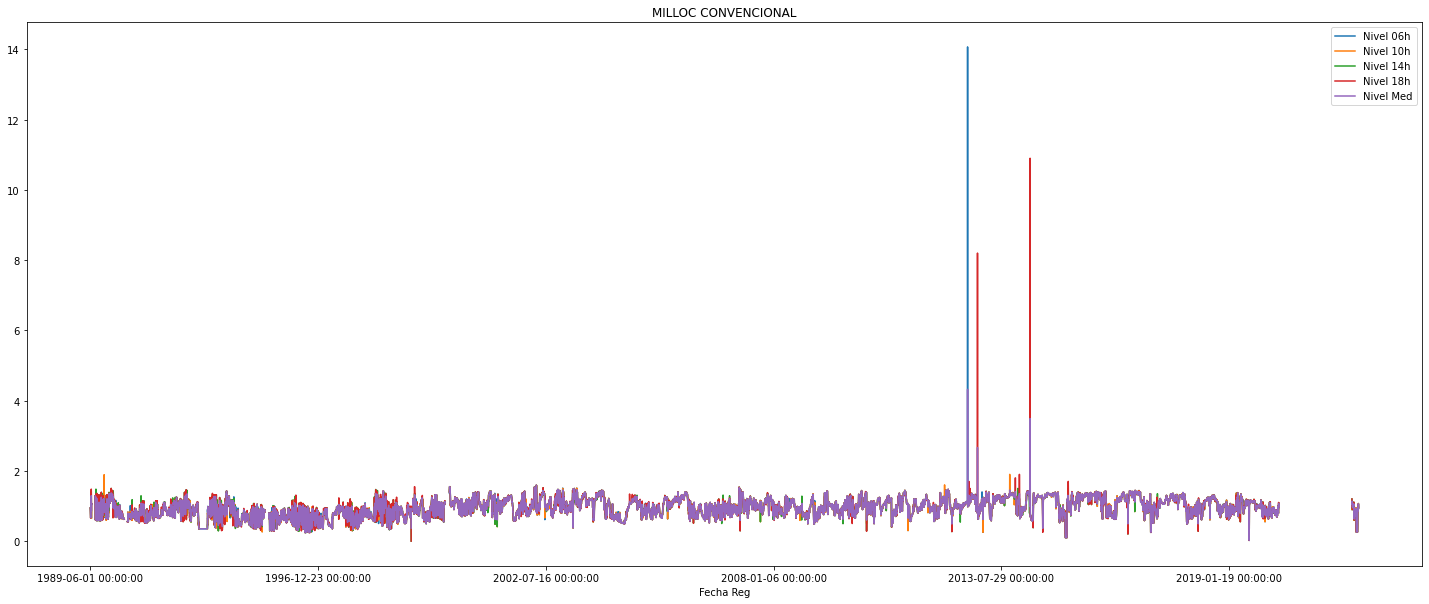

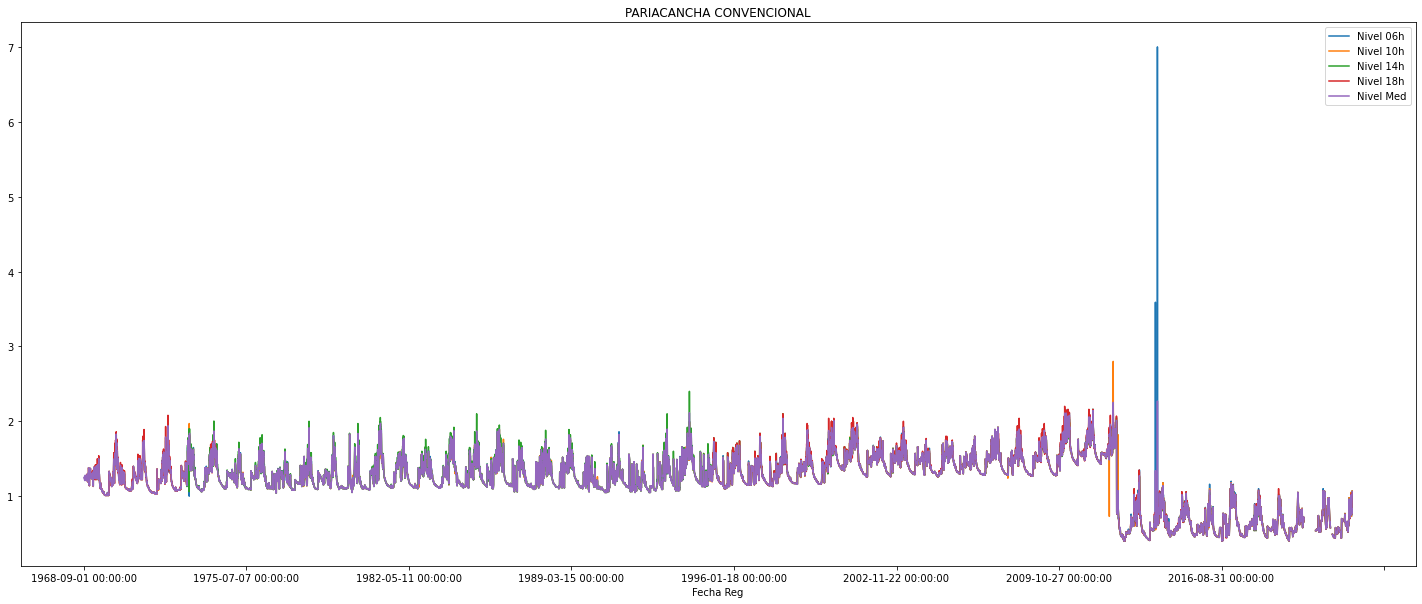

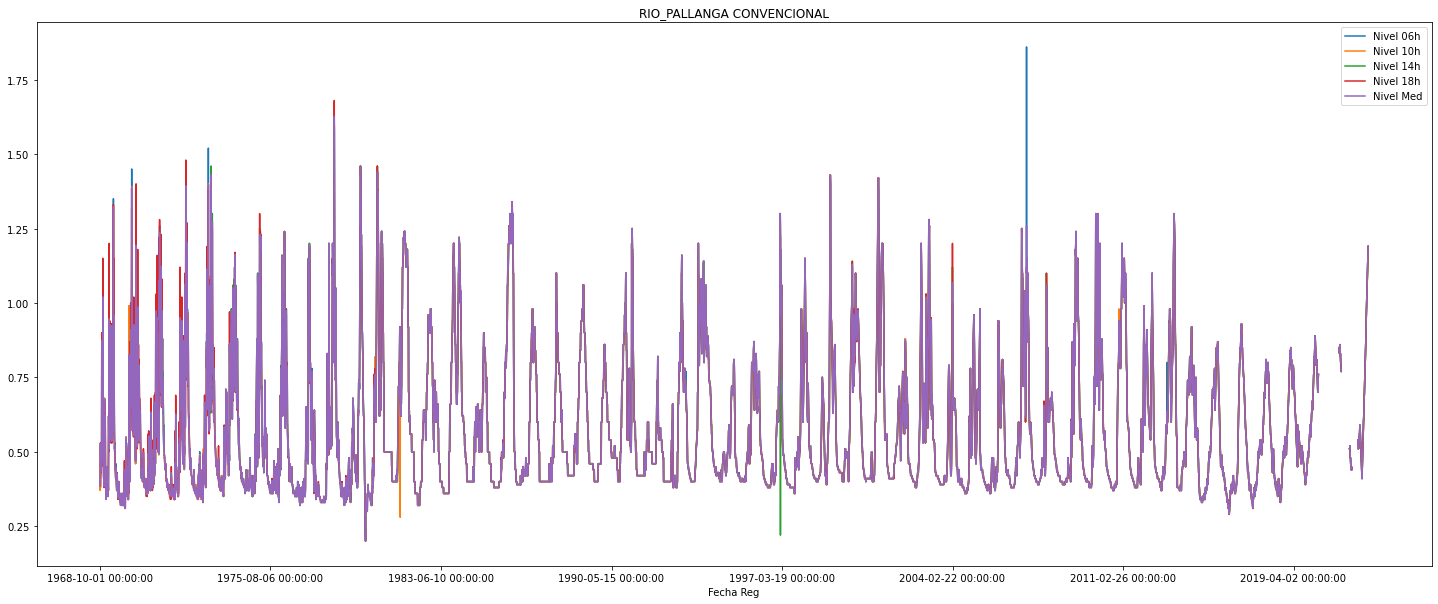

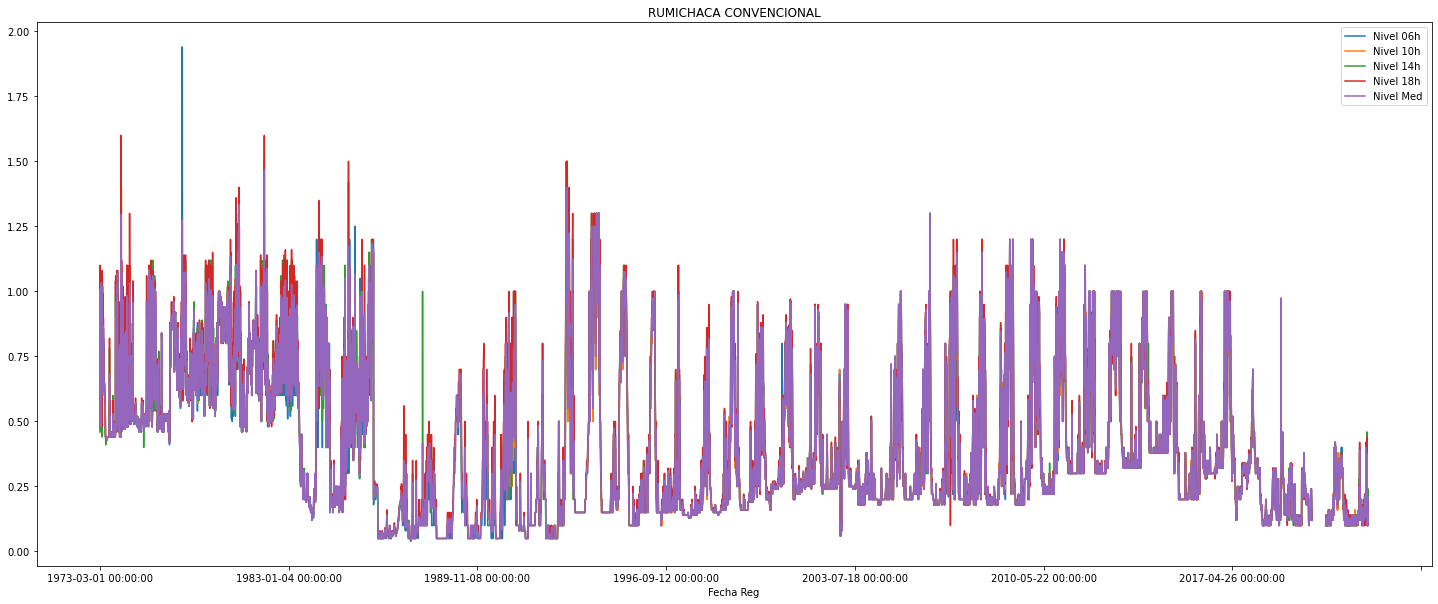

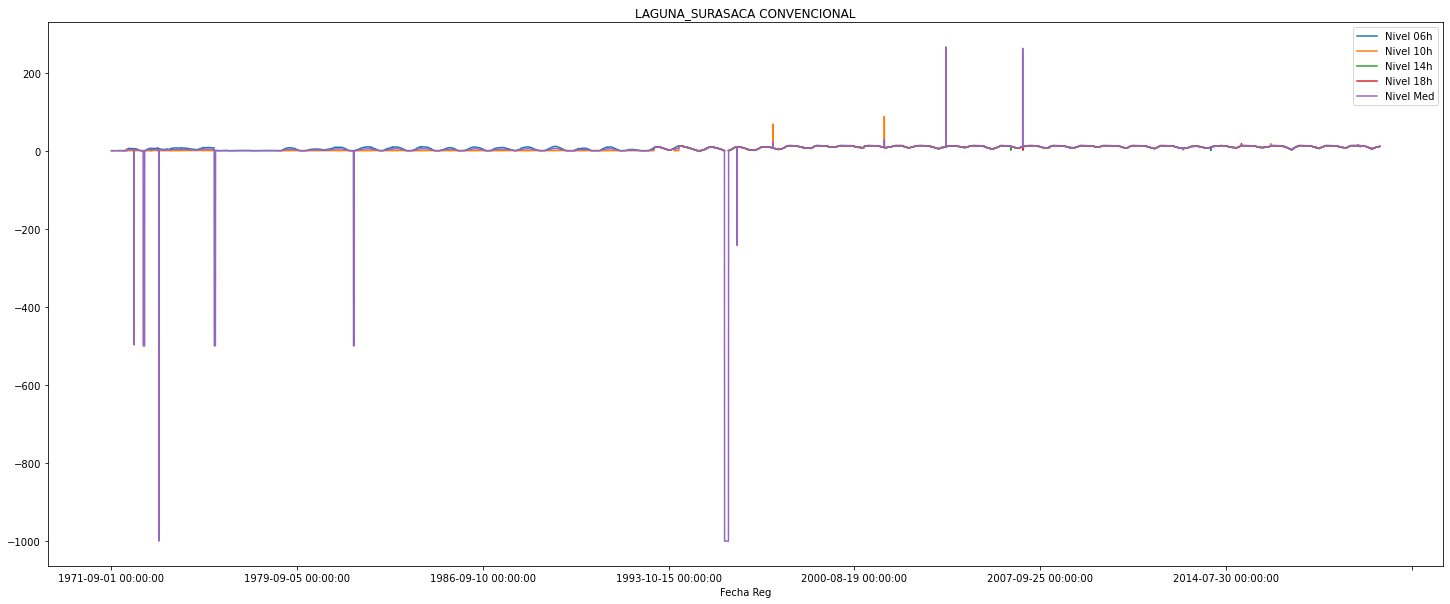

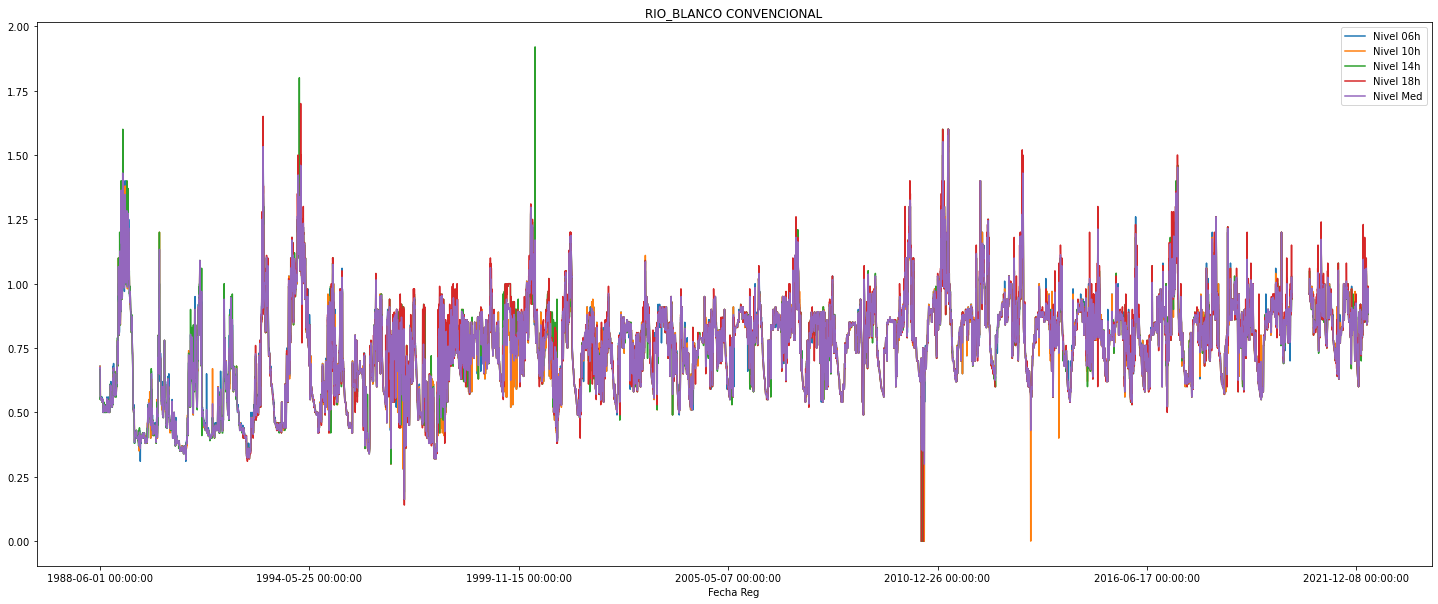

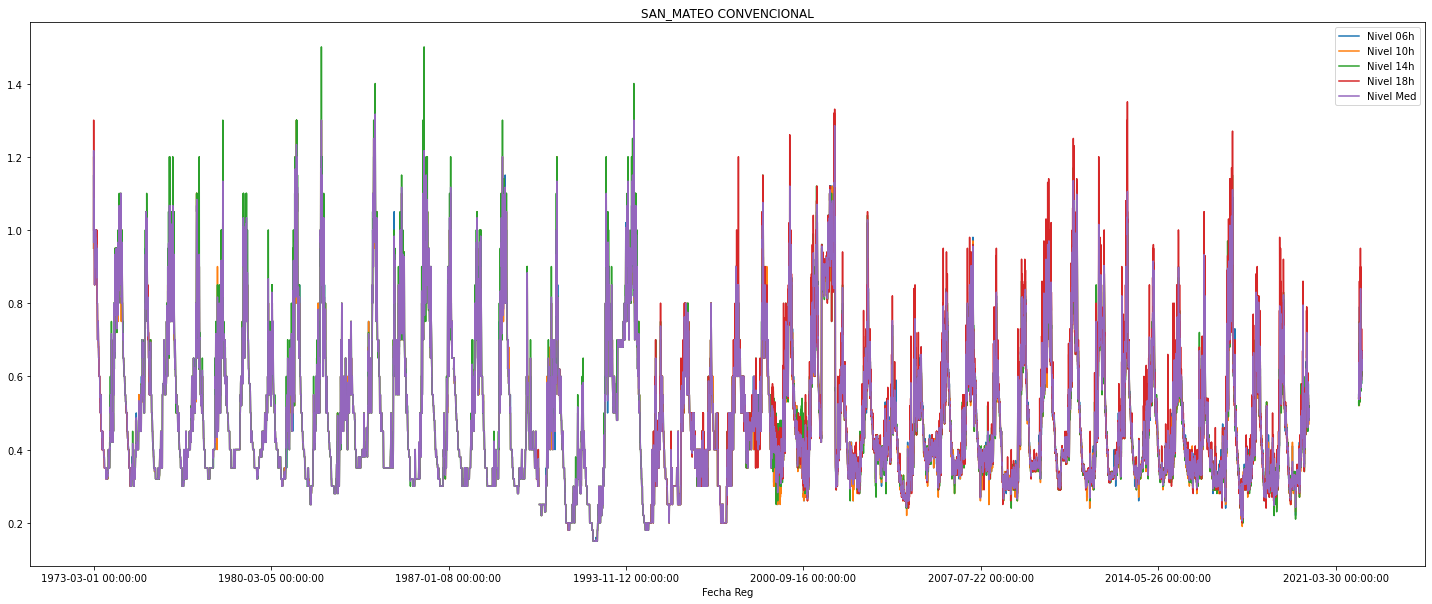

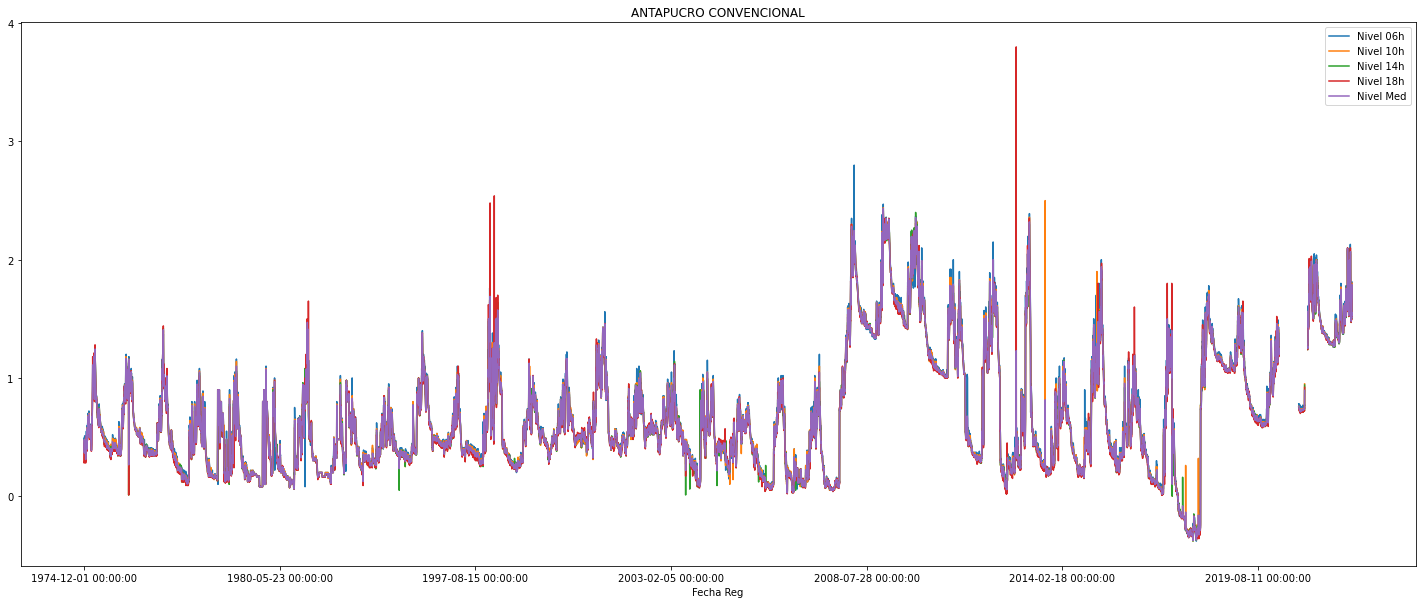

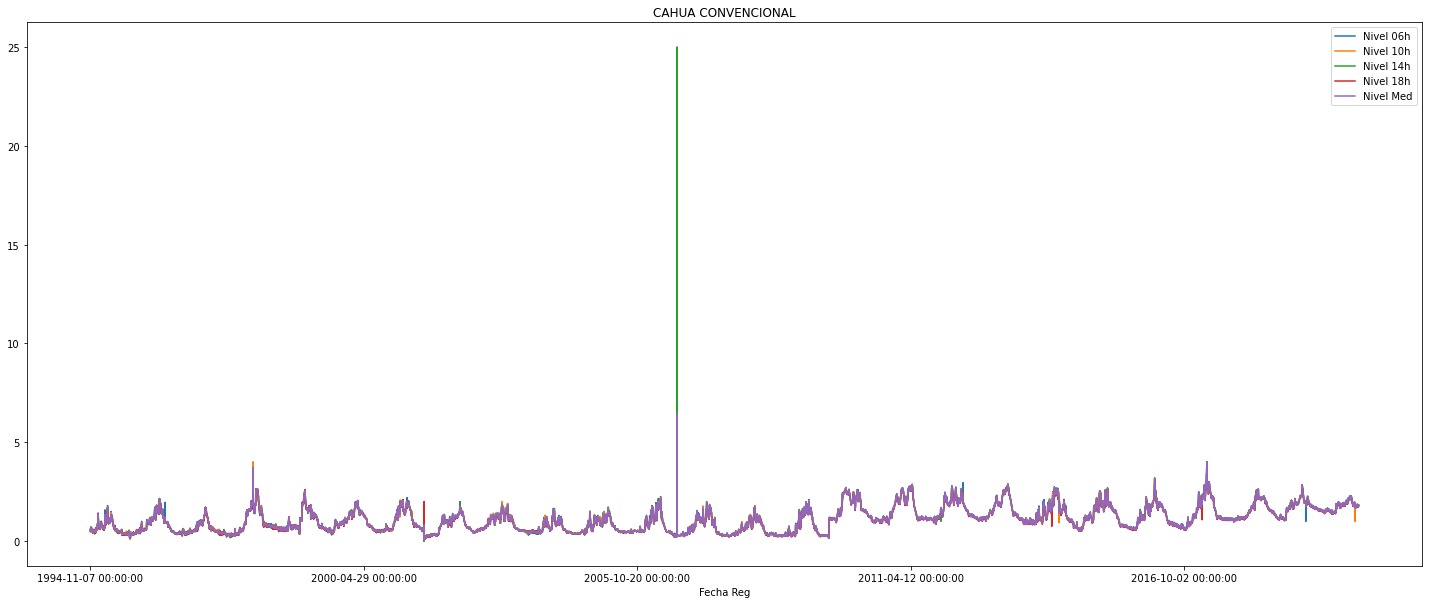

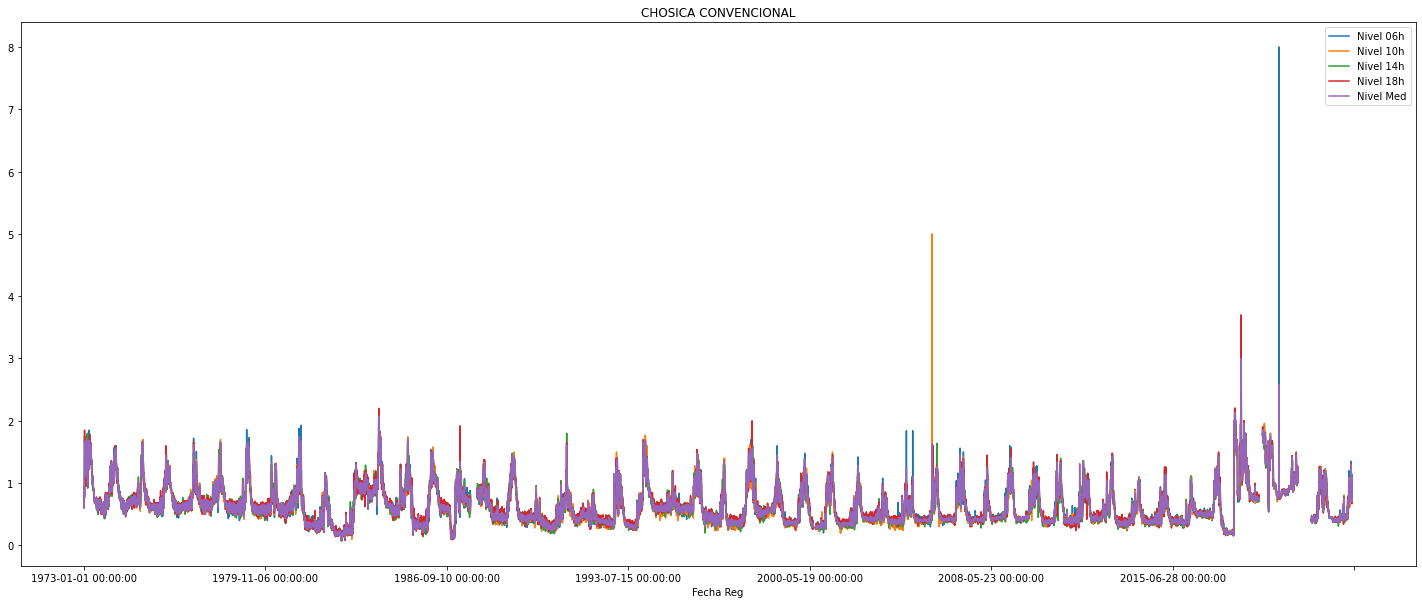

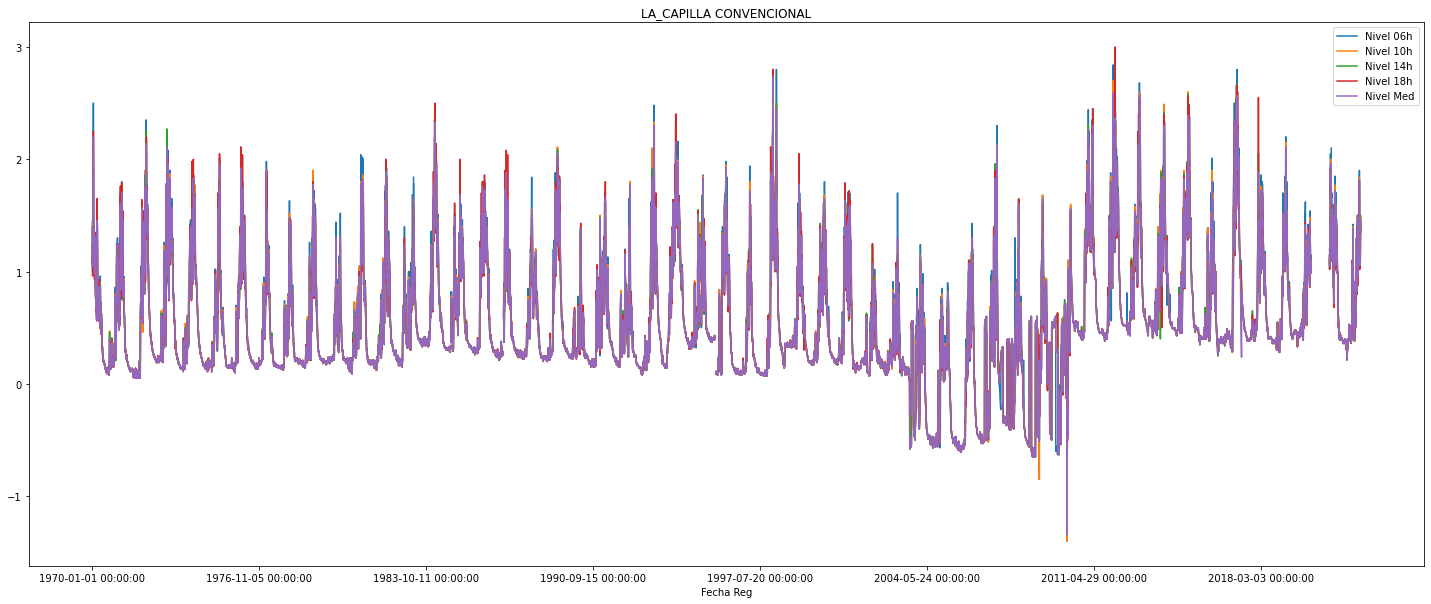

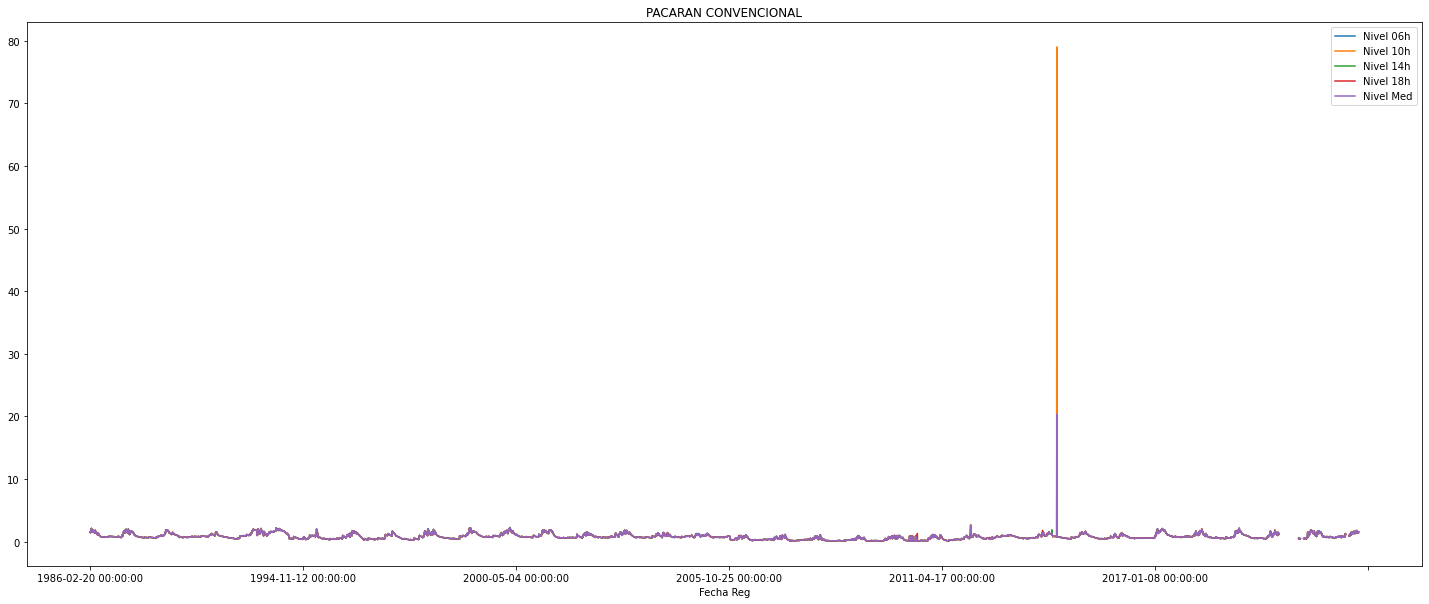

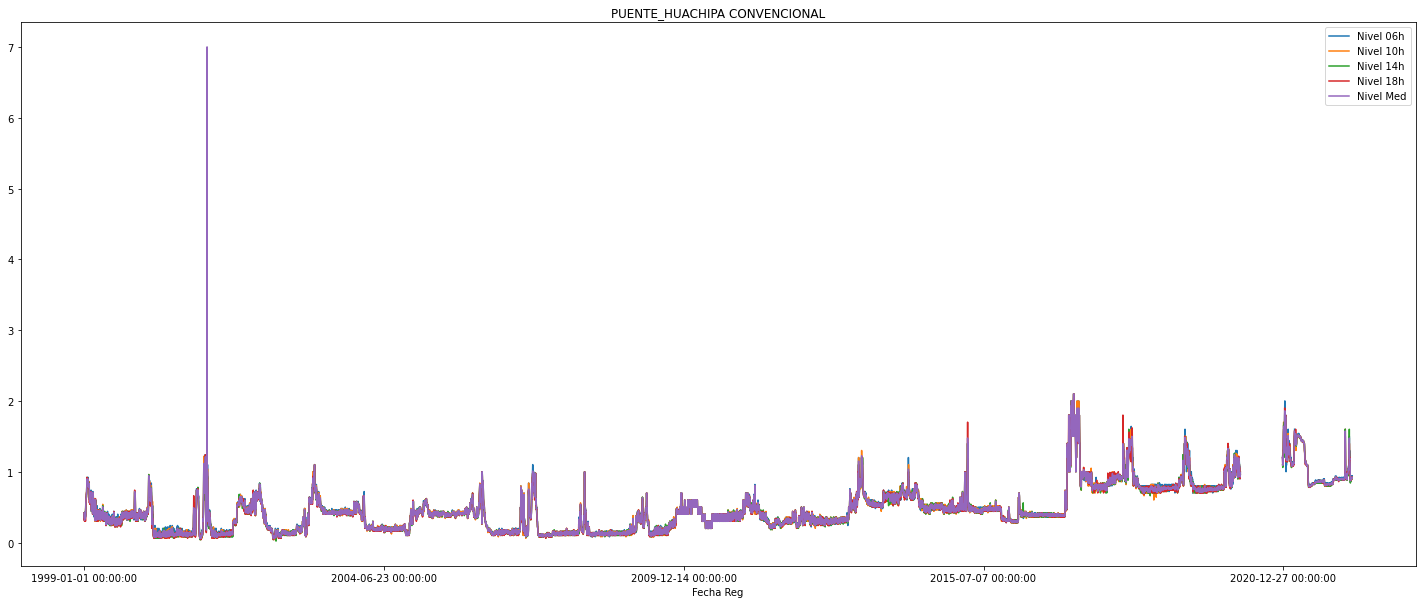

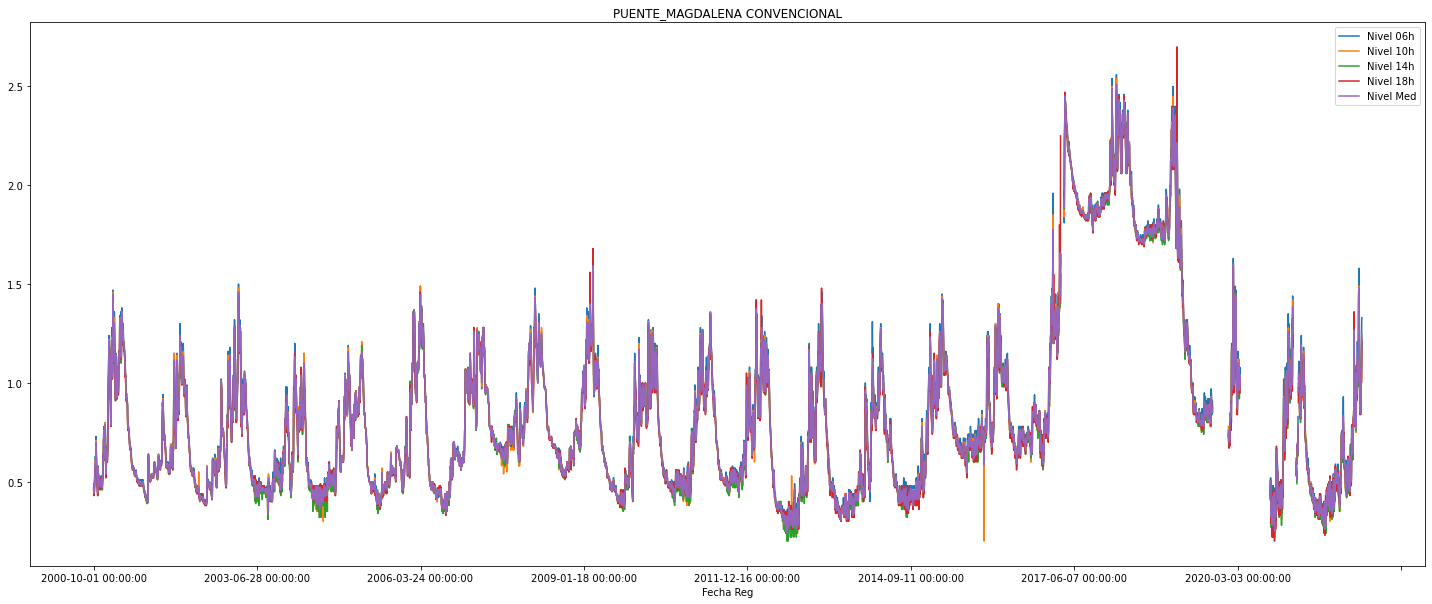

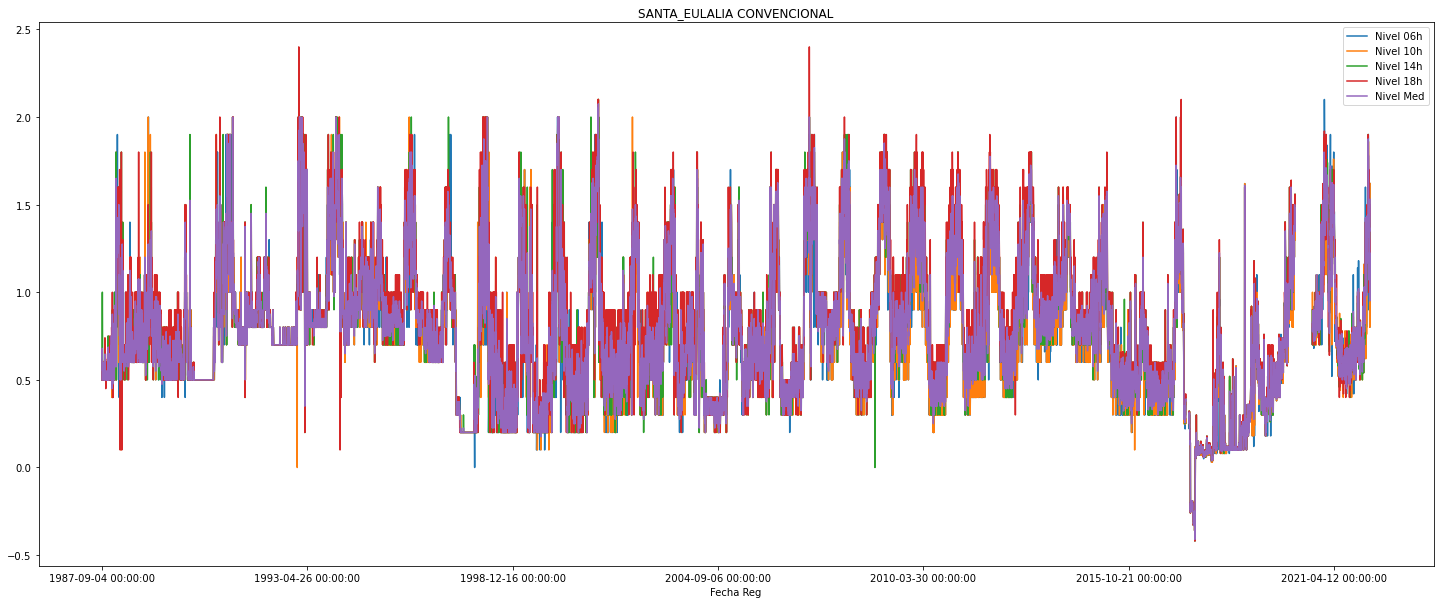

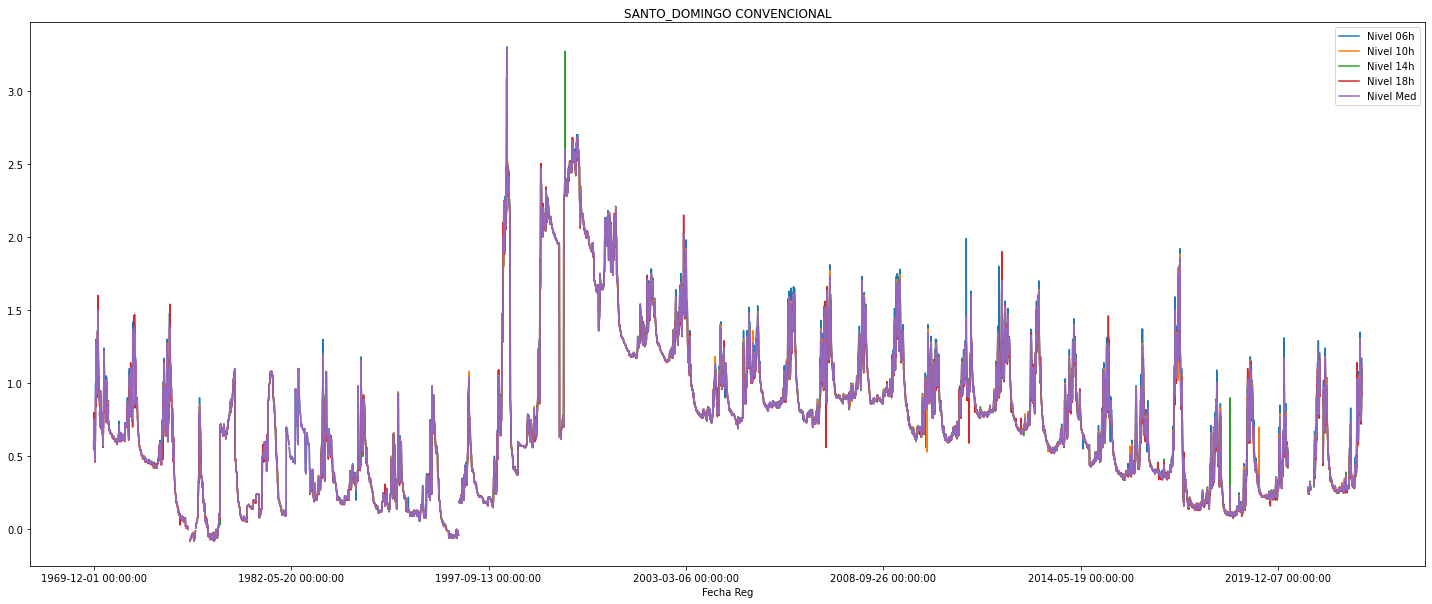

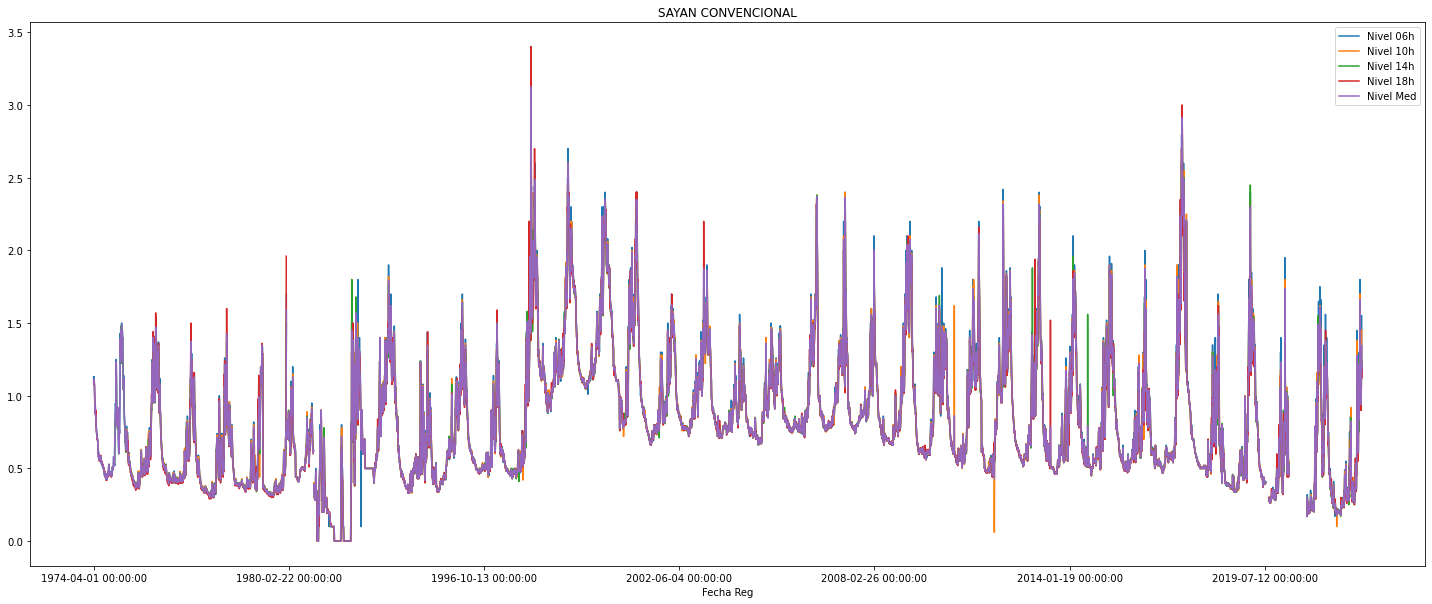

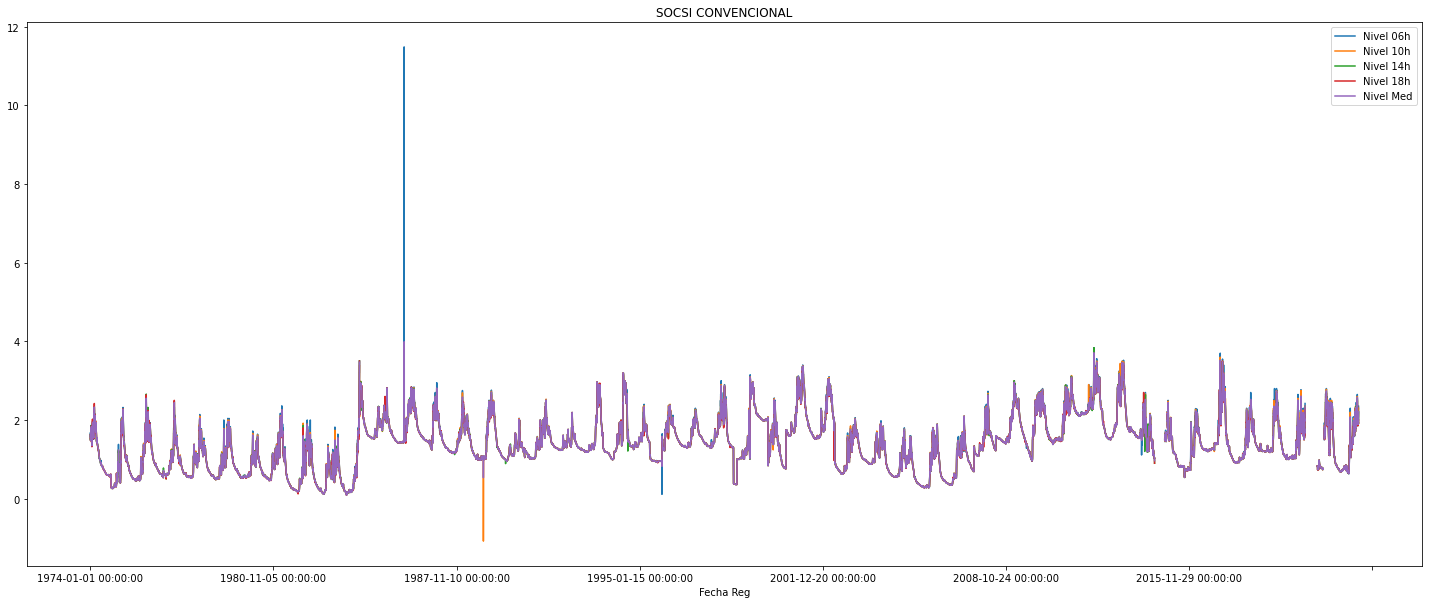

In [5]:
DZ4=Estacion_convencional.estaciones_por_dz(4)
Estacion_convencional.plot_dz_niveles()

In [6]:
#Estacion_convencional.stats_dz_niveles()

In [7]:
Estadisticos=pd.concat(Estacion_convencional.max_historic_and_previous())
Estadisticos.to_excel('../data/horizontes/Estadisticos.xlsx',index=False)
Estadisticos.head(20)

Estaciones  max año previo  max historico  \
Nivel 06h    AUTISHA CONVENCIONAL Nivel 06h          1.9000          3.000   
Nivel 10h    AUTISHA CONVENCIONAL Nivel 10h          1.7000          3.000   
Nivel 14h    AUTISHA CONVENCIONAL Nivel 14h          1.7000          3.000   
Nivel 18h    AUTISHA CONVENCIONAL Nivel 18h          1.5000          3.000   
Nivel Med    AUTISHA CONVENCIONAL Nivel Med          1.7000          3.000   
Nivel 06h  OBRAJILLO CONVENCIONAL Nivel 06h          1.7100          1.860   
Nivel 10h  OBRAJILLO CONVENCIONAL Nivel 10h          1.6800          1.940   
Nivel 14h  OBRAJILLO CONVENCIONAL Nivel 14h          1.7100          1.940   
Nivel 18h  OBRAJILLO CONVENCIONAL Nivel 18h          1.7600          2.000   
Nivel Med  OBRAJILLO CONVENCIONAL Nivel Med          1.6950          1.895   
Nivel 06h      PICOY CONVENCIONAL Nivel 06h          1.0700          6.900   
Nivel 10h      PICOY CONVENCIONAL Nivel 10h          1.0500         68.000   
Nivel 14h      PICOY CONVENCIONAL Nivel 14h          1.0500          2.000   
Nivel 18h      PICOY CONVENCIONAL Nivel 18h          1.0500          8.000   
Nivel Med      PICOY CONVENCIONAL Nivel Med          1.0475         84.270   
Nivel 06h  SAN_PEDRO CONVENCIONAL Nivel 06h          2.1900          4.200   
Nivel 10h  SAN_PEDRO CONVENCIONAL Nivel 10h          2.2200          4.085   
Nivel 14h  SAN_PEDRO CONVENCIONAL Nivel 14h             NaN            NaN   
Nivel 18h  SAN_PEDRO CONVENCIONAL Nivel 18h             NaN            NaN   
Nivel Med  SAN_PEDRO CONVENCIONAL Nivel Med          2.2200          4.085   

           max año previo estiaje  max año previo avenida  \
Nivel 06h                  0.8000                  1.9000   
Nivel 10h                  0.8000                  1.7000   
Nivel 14h                  0.9000                  1.7000   
Nivel 18h                  0.9000                  1.5000   
Nivel Med                  0.8500                  1.7000   
Nivel 06h                  1.1000                  1.7100   
Nivel 10h                  1.1000                  1.6800   
Nivel 14h                  1.0900                  1.7100   
Nivel 18h                  1.0900                  1.7600   
Nivel Med                  1.0950                  1.6950   
Nivel 06h                  0.3000                  1.0700   
Nivel 10h                  0.3200                  1.0500   
Nivel 14h                  0.3200                  1.0500   
Nivel 18h                  0.3000                  1.0500   
Nivel Med                  0.3075                  1.0475   
Nivel 06h                  0.8400                  2.1600   
Nivel 10h                  0.8675                  2.2050   
Nivel 14h                     NaN                     NaN   
Nivel 18h                     NaN                     NaN   
Nivel Med                  0.8675                  2.2050   

           max año historico estiaje  max año historico avenida  
Nivel 06h                     1.5000                     3.0000  
Nivel 10h                     1.5000                     3.0000  
Nivel 14h                     1.5000                     3.0000  
Nivel 18h                     1.5000                     3.0000  
Nivel Med                     1.5000                     3.0000  
Nivel 06h                     1.2500                     1.8600  
Nivel 10h                     1.2500                     1.9400  
Nivel 14h                     1.4000                     1.9400  
Nivel 18h                     1.4000                     2.0000  
Nivel Med                     1.2650                     1.8950  
Nivel 06h                     3.1000                     6.9000  
Nivel 10h                     0.6500                    68.0000  
Nivel 14h                     0.6500                     2.0000  
Nivel 18h                     0.5500                     8.0000  
Nivel Med                    84.2700                    17.5025  
Nivel 06h                     1.9700                    

# Estaciones de la DZ 9

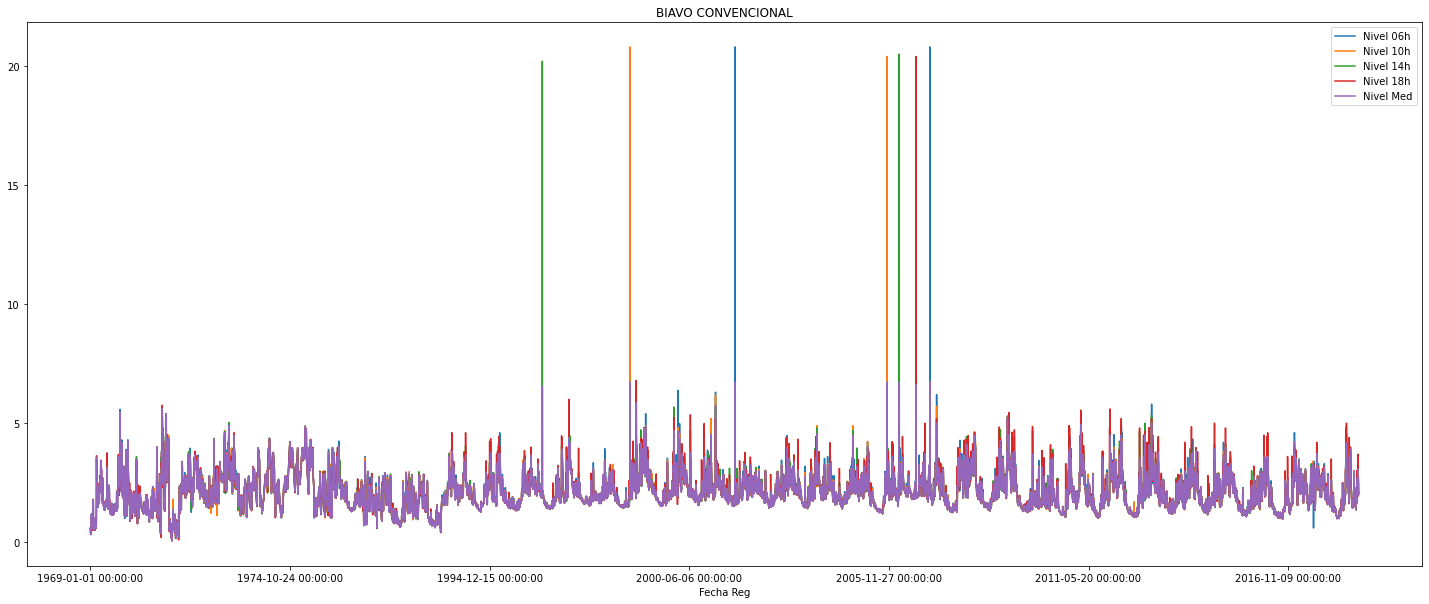

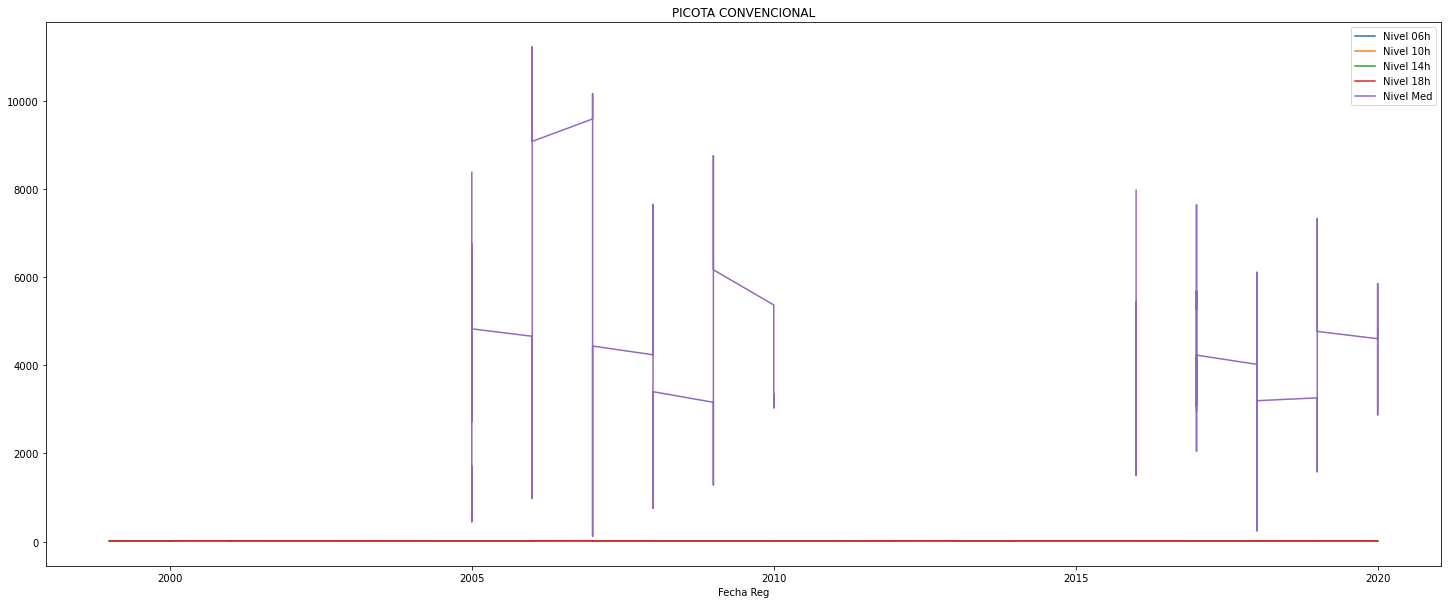

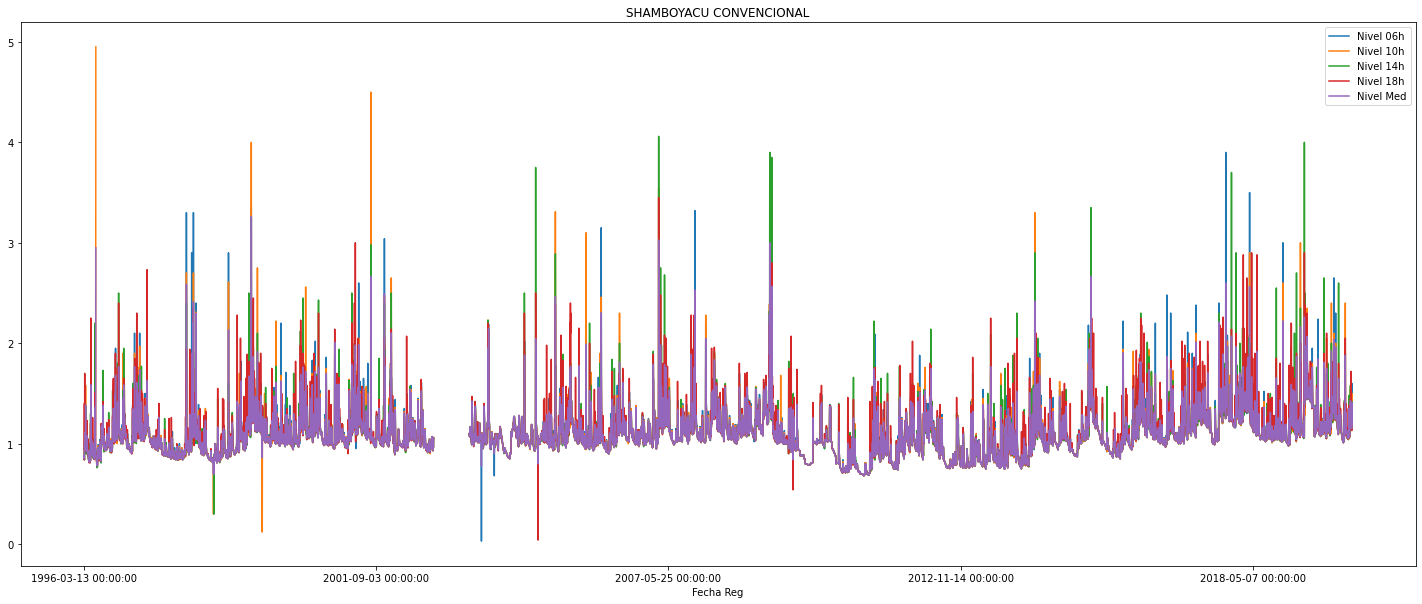

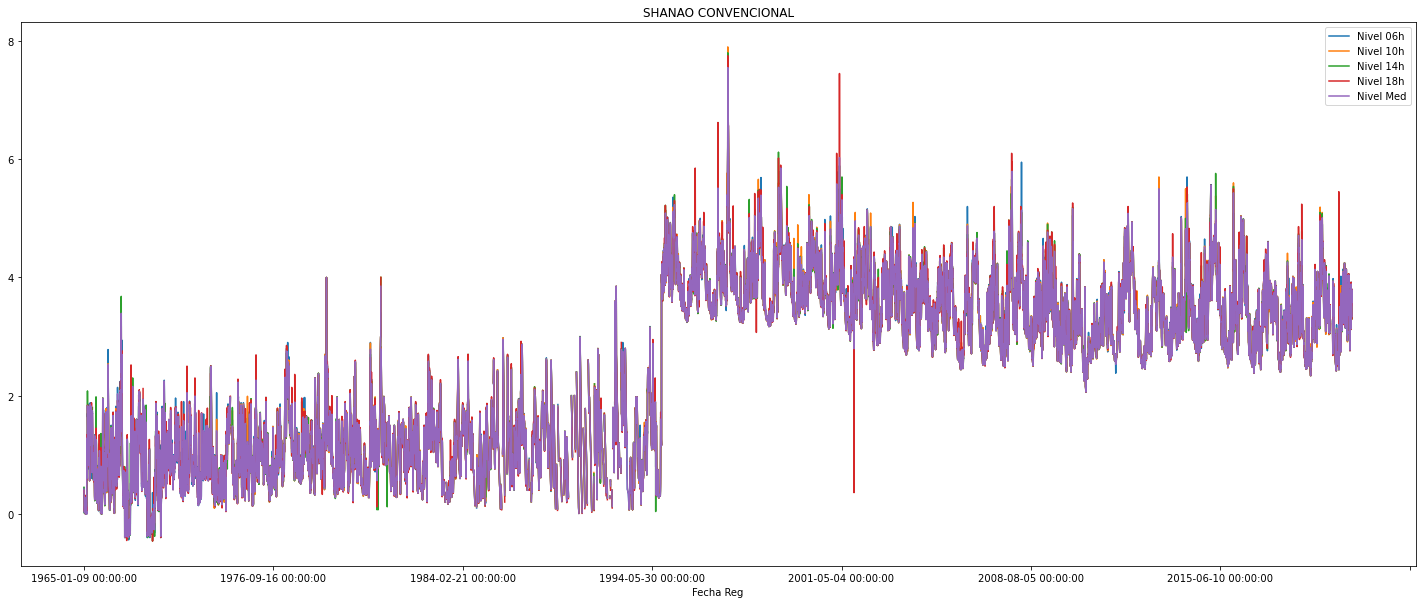

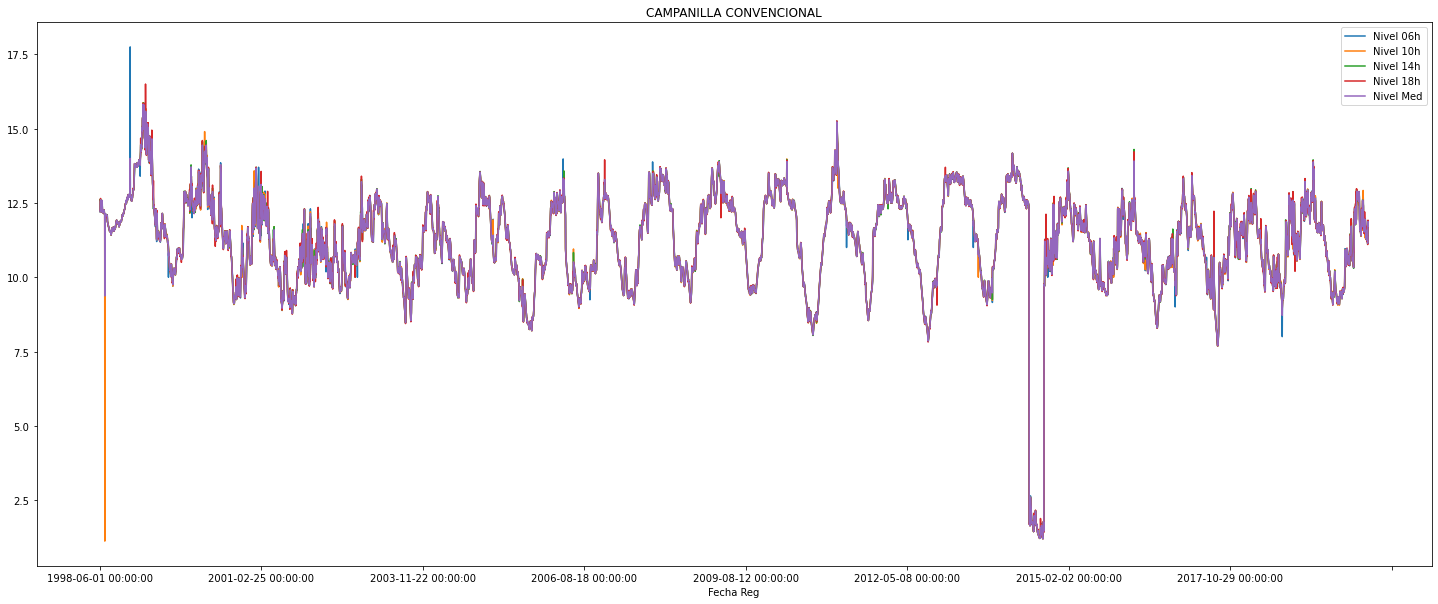

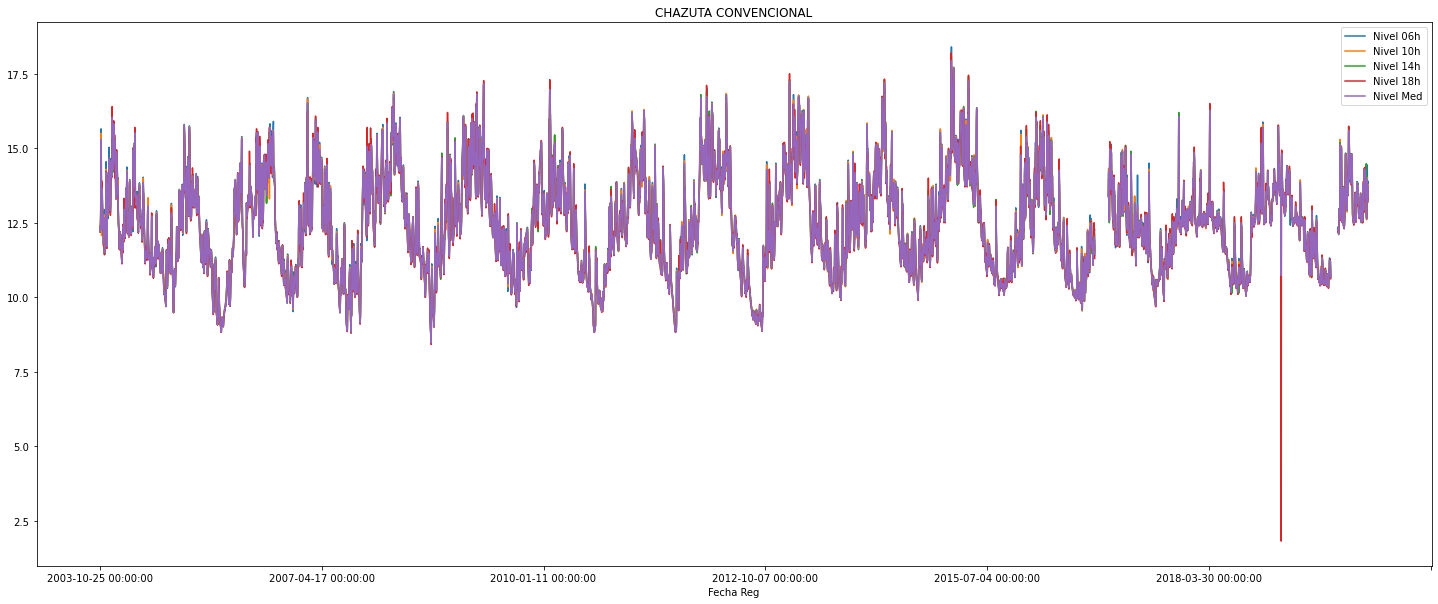

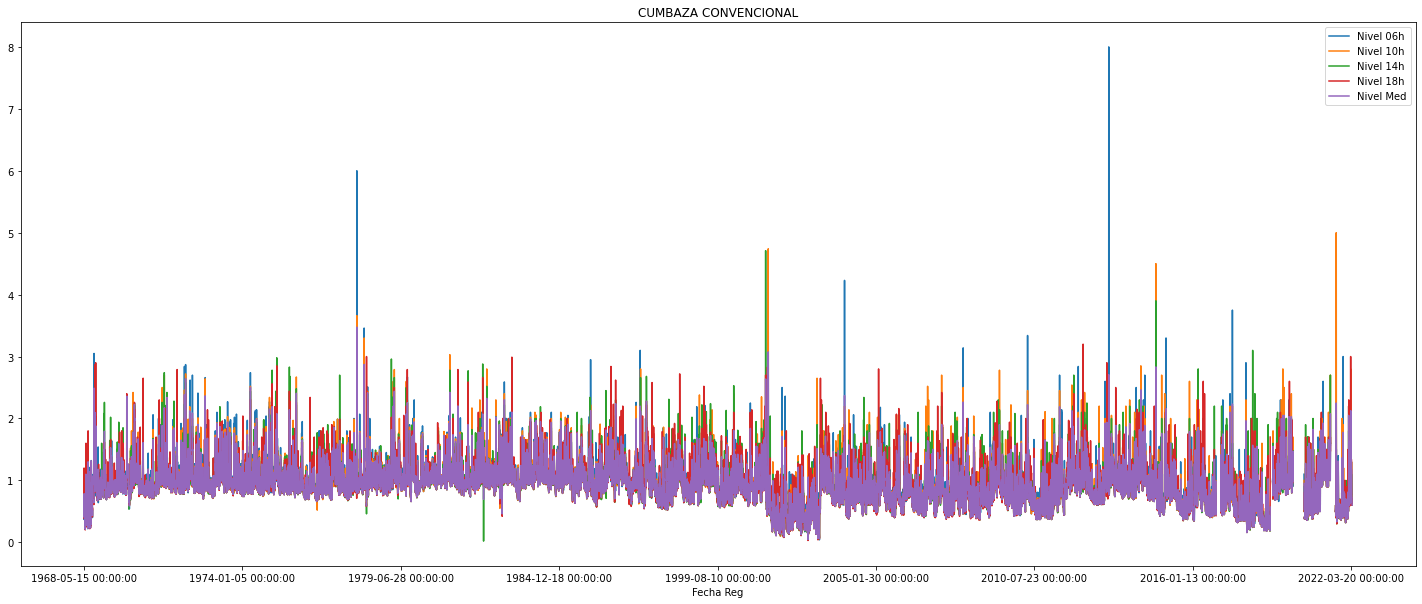

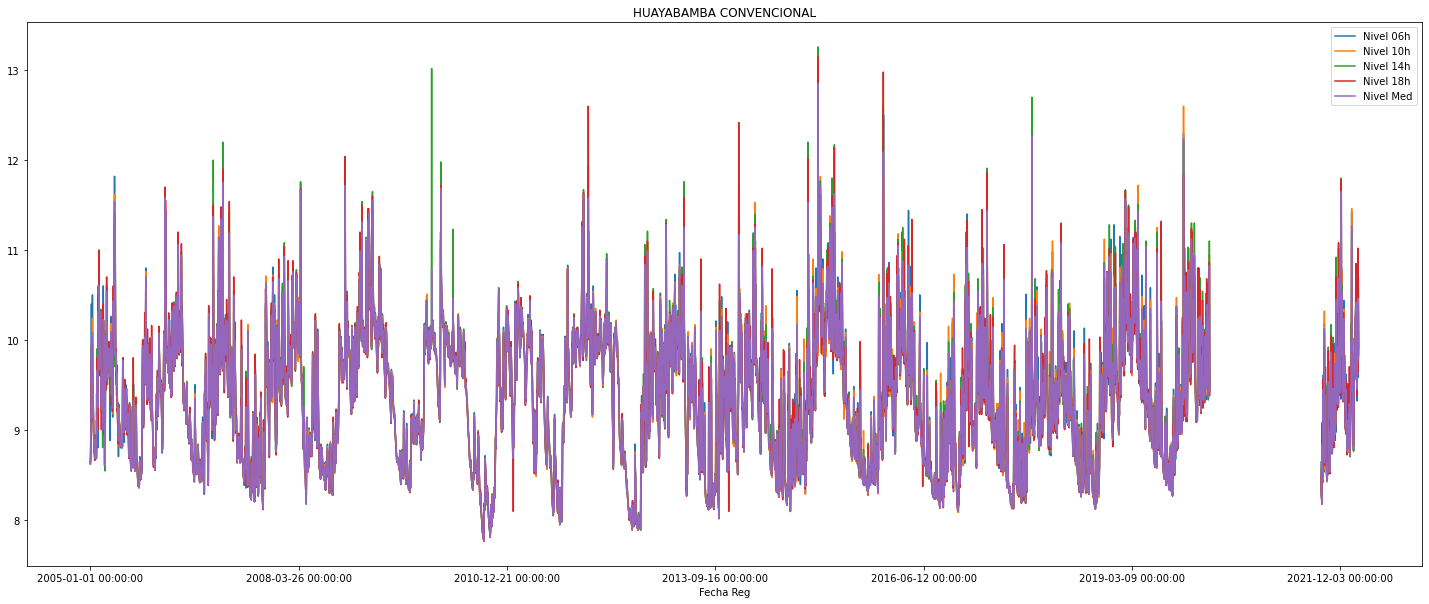

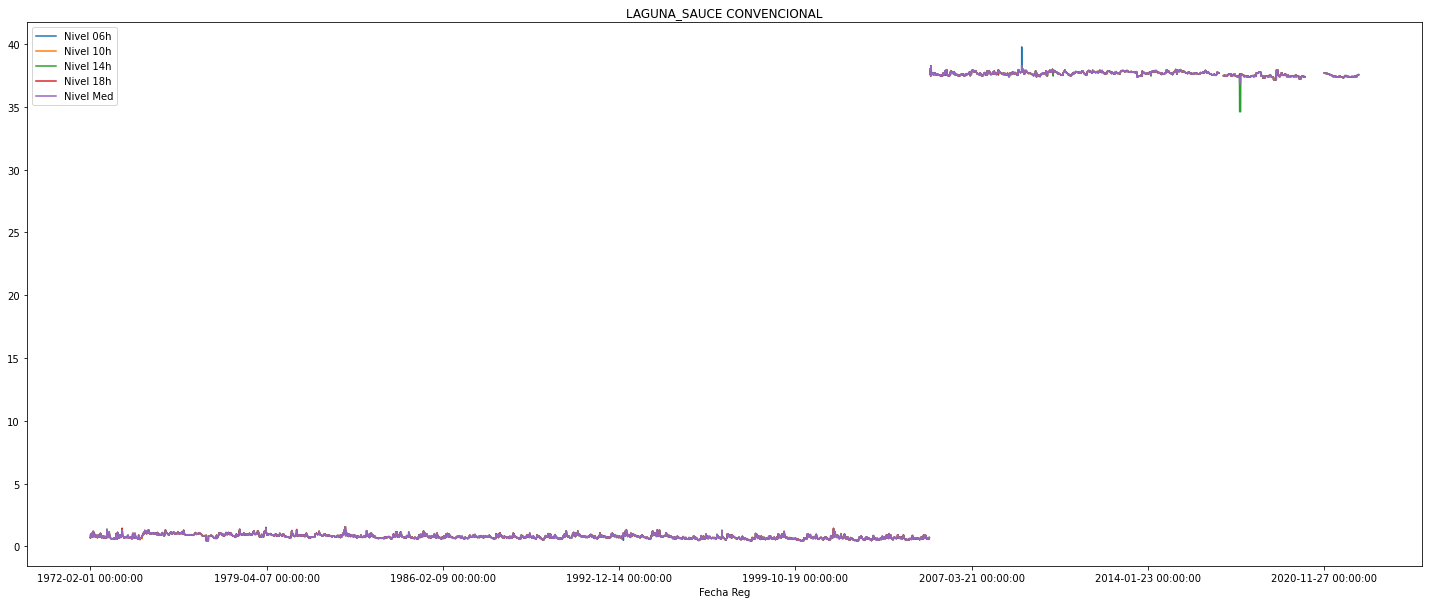

In [8]:
DZ9=Estacion_convencional.estaciones_por_dz(9)
Estacion_convencional.plot_dz_niveles()

In [9]:
#Estacion_convencional.stats_dz_niveles()

In [10]:
Estadisticos=pd.concat(Estacion_convencional.max_historic_and_previous())

PICOTA CONVENCIONALtiene menos de dos años de registro [1970]


In [11]:
Estadisticos.head(20)

Estaciones  max año previo  max historico  \
Nivel 06h    AUTISHA CONVENCIONAL Nivel 06h          1.9000          3.000   
Nivel 10h    AUTISHA CONVENCIONAL Nivel 10h          1.7000          3.000   
Nivel 14h    AUTISHA CONVENCIONAL Nivel 14h          1.7000          3.000   
Nivel 18h    AUTISHA CONVENCIONAL Nivel 18h          1.5000          3.000   
Nivel Med    AUTISHA CONVENCIONAL Nivel Med          1.7000          3.000   
Nivel 06h  OBRAJILLO CONVENCIONAL Nivel 06h          1.7100          1.860   
Nivel 10h  OBRAJILLO CONVENCIONAL Nivel 10h          1.6800          1.940   
Nivel 14h  OBRAJILLO CONVENCIONAL Nivel 14h          1.7100          1.940   
Nivel 18h  OBRAJILLO CONVENCIONAL Nivel 18h          1.7600          2.000   
Nivel Med  OBRAJILLO CONVENCIONAL Nivel Med          1.6950          1.895   
Nivel 06h      PICOY CONVENCIONAL Nivel 06h          1.0700          6.900   
Nivel 10h      PICOY CONVENCIONAL Nivel 10h          1.0500         68.000   
Nivel 14h      PICOY CONVENCIONAL Nivel 14h          1.0500          2.000   
Nivel 18h      PICOY CONVENCIONAL Nivel 18h          1.0500          8.000   
Nivel Med      PICOY CONVENCIONAL Nivel Med          1.0475         84.270   
Nivel 06h  SAN_PEDRO CONVENCIONAL Nivel 06h          2.1900          4.200   
Nivel 10h  SAN_PEDRO CONVENCIONAL Nivel 10h          2.2200          4.085   
Nivel 14h  SAN_PEDRO CONVENCIONAL Nivel 14h             NaN            NaN   
Nivel 18h  SAN_PEDRO CONVENCIONAL Nivel 18h             NaN            NaN   
Nivel Med  SAN_PEDRO CONVENCIONAL Nivel Med          2.2200          4.085   

           max año previo estiaje  max año previo avenida  \
Nivel 06h                  0.8000                  1.9000   
Nivel 10h                  0.8000                  1.7000   
Nivel 14h                  0.9000                  1.7000   
Nivel 18h                  0.9000                  1.5000   
Nivel Med                  0.8500                  1.7000   
Nivel 06h                  1.1000                  1.7100   
Nivel 10h                  1.1000                  1.6800   
Nivel 14h                  1.0900                  1.7100   
Nivel 18h                  1.0900                  1.7600   
Nivel Med                  1.0950                  1.6950   
Nivel 06h                  0.3000                  1.0700   
Nivel 10h                  0.3200                  1.0500   
Nivel 14h                  0.3200                  1.0500   
Nivel 18h                  0.3000                  1.0500   
Nivel Med                  0.3075                  1.0475   
Nivel 06h                  0.8400                  2.1600   
Nivel 10h                  0.8675                  2.2050   
Nivel 14h                     NaN                     NaN   
Nivel 18h                     NaN                     NaN   
Nivel Med                  0.8675                  2.2050   

           max año historico estiaje  max año historico avenida  
Nivel 06h                     1.5000                     3.0000  
Nivel 10h                     1.5000                     3.0000  
Nivel 14h                     1.5000                     3.0000  
Nivel 18h                     1.5000                     3.0000  
Nivel Med                     1.5000                     3.0000  
Nivel 06h                     1.2500                     1.8600  
Nivel 10h                     1.2500                     1.9400  
Nivel 14h                     1.4000                     1.9400  
Nivel 18h                     1.4000                     2.0000  
Nivel Med                     1.2650                     1.8950  
Nivel 06h                     3.1000                     6.9000  
Nivel 10h                     0.6500                    68.0000  
Nivel 14h                     0.6500                     2.0000  
Nivel 18h                     0.5500                     8.0000  
Nivel Med                    84.2700                    17.5025  
Nivel 06h                     1.9700                    

# Estaciones faltantes en el maestro

Estaciones con pocos años de registro estan faltando en el maestro 

In [12]:
Maestro=Estacion_convencional.get_Maestro()

directory ='../data/DZ/DZ_04_LIMA_NIV/'
table_names = [file.split('.')[0].split('_')[1] for file in os.listdir(directory)]
tables = tables_in_sqlite_db(conn)
for i,code in enumerate(table_names):
    print(code,Maestro[Maestro.CODIGO==code][['DZ','NOMBRE_ESTACION']])


filtro=Maestro[Maestro.DZ==4]
name=list(filtro.NOMBRE_ESTACION+' '+filtro.CATEGORIA)
for i,estacion in enumerate(filtro.CODIGO):
    estacion='T'+str(estacion)
    if estacion in tables:
        print(estacion,name[i])

203003      DZ NOMBRE_ESTACION
141   4       ANTAPUCRO
202903    DZ NOMBRE_ESTACION
6   4         AUTISHA
202404      DZ NOMBRE_ESTACION
142   4           CAHUA
111070 Empty DataFrame
Columns: [DZ, NOMBRE_ESTACION]
Index: []
203305 Empty DataFrame
Columns: [DZ, NOMBRE_ESTACION]
Index: []
202906      DZ NOMBRE_ESTACION
144   4         CHOSICA
203004 Empty DataFrame
Columns: [DZ, NOMBRE_ESTACION]
Index: []
203101      DZ NOMBRE_ESTACION
147   4      LA_CAPILLA
202606 Empty DataFrame
Columns: [DZ, NOMBRE_ESTACION]
Index: []
202601     DZ  NOMBRE_ESTACION
93   4  LAGUNA_SURASACA
202929 Empty DataFrame
Columns: [DZ, NOMBRE_ESTACION]
Index: []
202902     DZ NOMBRE_ESTACION
75   4          MILLOC
202802    DZ NOMBRE_ESTACION
9   4       OBRAJILLO
203303      DZ NOMBRE_ESTACION
150   4         PACARAN
202801     DZ NOMBRE_ESTACION
76   4     PARIACANCHA
202607     DZ NOMBRE_ESTACION
11   4           PICOY
202910      DZ  NOMBRE_ESTACION
155   4  PUENTE_HUACHIPA
111151      DZ   NOMBRE_ESTACION